In [12]:
import pandas as pd

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

    





In [14]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")
s814_time = get_s814_time(s814_df.columns)

<AxesSubplot:>

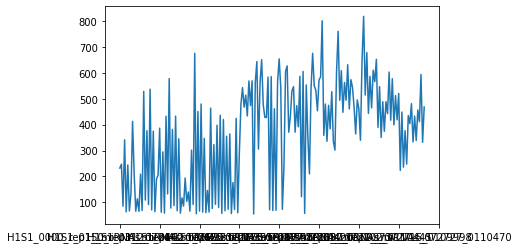

In [3]:
s745_df.iloc[0,:].plot.line()

<AxesSubplot:>

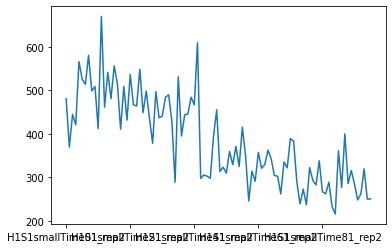

In [15]:
s814_df.iloc[0,:].plot.line()

<AxesSubplot:>

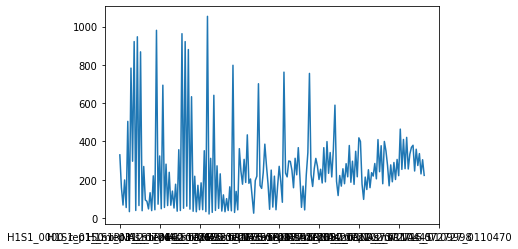

In [6]:
s745_df.iloc[1,:].plot.line()

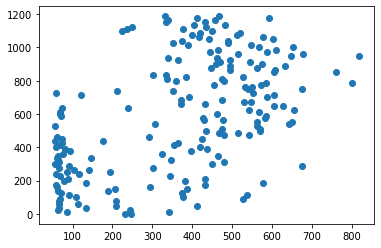

In [17]:
import matplotlib
matplotlib.pyplot.scatter(s745_df.iloc[0,:],time)


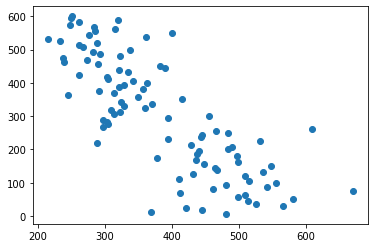

In [19]:
matplotlib.pyplot.scatter(s814_df.iloc[0,:],s814_time)